# TP Data Lake Groupe 3

- Gills Daryl KETCHA
- Narcisse Cabrel TSAFACK
- Frédéric FERNANDES DA COSTA
- Jennifer HOUNGBEDJI

## 0. Initialisation et Configuration Globale

In [1]:
# Importations
import time
import json
import random
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType
from pyspark.sql.window import Window

# Configuration de la session Spark
spark = SparkSession.builder \
    .appName("TP Final Data Lake - Groupe 3") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.6.0,org.apache.hadoop:hadoop-aws:3.4.1,com.amazonaws:aws-java-sdk-bundle:1.12.262,org.apache.spark:spark-sql-kafka-0-10_2.13:3.5.0") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

# Variables globales
DATE_JOUR = datetime.now().strftime("%Y-%m-%d")
JDBC_URL = "jdbc:postgresql://postgres:5432/app"
JDBC_PROPS = {
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver"
}
KAFKA_BROKER = "broker:29092"
TOPIC_NAME = "ventes-temps-reel"

print(f"Session Spark initialisée. Date : {DATE_JOUR}")

Session Spark initialisée. Date : 2026-01-18


## 1. PHASE 1 : Ingestion Bronze (Responsable : Jennifer)
Objectif : Extraire les données brutes de PostgreSQL et les sauvegarder au format Parquet dans MinIO sans transformation majeure.

In [2]:
# --- CODE JENNIFER ---

def ingerer_table_bronze(table_name):
    """
    Lit une table Postgres et l'ecrit dans s3a://bronze/{table}/{date}
    """
    print(f"[Bronze] Ingestion de la table : {table_name}...")
    
    # Lecture JDBC
    df = spark.read.jdbc(url=JDBC_URL, table=table_name, properties=JDBC_PROPS)
    
    # Ajout metadonnees techniques (tracabilite)
    df_meta = df.withColumn("_ingestion_timestamp", F.current_timestamp()) \
                .withColumn("_source", F.lit("postgresql"))
    
    # Ecriture dans MinIO
    chemin_sortie = f"s3a://bronze/{table_name}/{DATE_JOUR}"
    df_meta.write.mode("overwrite").parquet(chemin_sortie)
    
    print(f"[Bronze] Succes : {df.count()} lignes -> {chemin_sortie}")

# Liste des tables Northwind a ingerer
tables_a_ingerer = ["orders", "order_details", "products", "customers", "employees", "categories"]

for table in tables_a_ingerer:
    ingerer_table_bronze(table)

print("\n--- Phase 1 (Bronze) terminee ---")

[Bronze] Ingestion de la table : orders...
[Bronze] Succes : 830 lignes -> s3a://bronze/orders/2026-01-18
[Bronze] Ingestion de la table : order_details...
[Bronze] Succes : 2155 lignes -> s3a://bronze/order_details/2026-01-18
[Bronze] Ingestion de la table : products...
[Bronze] Succes : 77 lignes -> s3a://bronze/products/2026-01-18
[Bronze] Ingestion de la table : customers...
[Bronze] Succes : 91 lignes -> s3a://bronze/customers/2026-01-18
[Bronze] Ingestion de la table : employees...
[Bronze] Succes : 9 lignes -> s3a://bronze/employees/2026-01-18
[Bronze] Ingestion de la table : categories...
[Bronze] Succes : 8 lignes -> s3a://bronze/categories/2026-01-18

--- Phase 1 (Bronze) terminee ---


## 2. PHASE 2 : Transformations Silver (Responsable : Cabrel)
Objectif : Nettoyer les données, gérer les valeurs nulles et créer une table "Maître" dénormalisée (Jointures) facilitant l'analyse.

In [3]:
# --- CODE CABREL ---

print("[Silver] Chargement des donnees Bronze...")

# Lecture des fichiers Parquet generes par Jennifer
df_orders = spark.read.parquet(f"s3a://bronze/orders/{DATE_JOUR}")
df_details = spark.read.parquet(f"s3a://bronze/order_details/{DATE_JOUR}")
df_products = spark.read.parquet(f"s3a://bronze/products/{DATE_JOUR}")
df_customers = spark.read.parquet(f"s3a://bronze/customers/{DATE_JOUR}")
df_categories = spark.read.parquet(f"s3a://bronze/categories/{DATE_JOUR}")

# 1. Nettoyage et Calculs preliminaires
# Calcul du montant total par ligne (Prix * Quantite * (1 - Remise))
df_details_clean = df_details.withColumn(
    "line_total", 
    F.round(F.col("unit_price") * F.col("quantity") * (1 - F.col("discount")), 2)
)

# Standardisation des pays clients (Majuscules)
df_customers_clean = df_customers.withColumn("country", F.upper(F.col("country")))

# 2. Denormalisation (Creation de la table Master Ventes)
# Jointures : Details -> Orders -> Products -> Categories -> Customers
df_silver_master = df_details_clean.alias("d") \
    .join(df_orders.alias("o"), on="order_id", how="left") \
    .join(df_products.alias("p"), on="product_id", how="left") \
    .join(df_categories.alias("cat"), on="category_id", how="left") \
    .join(df_customers_clean.alias("c"), on="customer_id", how="left") \
    .select(
        F.col("o.order_id"),
        F.col("o.order_date"),
        F.col("c.company_name").alias("client"),
        F.col("c.country").alias("pays"),
        F.col("p.product_name").alias("produit"),
        F.col("cat.category_name").alias("categorie"),
        F.col("d.quantity"),
        F.col("d.unit_price"),
        F.col("d.line_total").alias("montant_final")
    )

# 3. Sauvegarde Silver
chemin_silver = f"s3a://silver/master_ventes/{DATE_JOUR}"
df_silver_master.write.mode("overwrite").parquet(chemin_silver)

print(f"[Silver] Vue denormalisee sauvegardee : {chemin_silver}")
df_silver_master.show(5)

print("\n--- Phase 2 (Silver) terminee ---")

[Silver] Chargement des donnees Bronze...
[Silver] Vue denormalisee sauvegardee : s3a://silver/master_ventes/2026-01-18
+--------+----------+--------------------+-------+--------------------+--------------+--------+----------+-------------+
|order_id|order_date|              client|   pays|             produit|     categorie|quantity|unit_price|montant_final|
+--------+----------+--------------------+-------+--------------------+--------------+--------+----------+-------------+
|   10248|1996-07-04|Vins et alcools C...| FRANCE|      Queso Cabrales|Dairy Products|      12|      14.0|        168.0|
|   10248|1996-07-04|Vins et alcools C...| FRANCE|Singaporean Hokki...|Grains/Cereals|      10|       9.8|         98.0|
|   10248|1996-07-04|Vins et alcools C...| FRANCE|Mozzarella di Gio...|Dairy Products|       5|      34.8|        174.0|
|   10249|1996-07-05|  Toms Spezialitäten|GERMANY|                Tofu|       Produce|       9|      18.6|        167.4|
|   10249|1996-07-05|  Toms Spezi

## 3. PHASE 3 : Kafka & Streaming (Responsable : Frédéric)
Objectif : Simuler des événements temps réel (Producteur Python) et les consommer avec Spark Structured Streaming.

### Partie A : Le Producteur (Simulation Python)

In [4]:
# --- CODE FREDERIC (PRODUCER) ---
from kafka import KafkaProducer, KafkaAdminClient
from kafka.admin import NewTopic
from kafka.errors import NoBrokersAvailable, NodeNotReadyError

def attendre_kafka_pret(timeout=60):
    """Fonction de sécurité pour attendre que Kafka démarre"""
    print("[Kafka] Tentative de connexion au broker...")
    start_time = time.time()
    
    while time.time() - start_time < timeout:
        try:
            admin = KafkaAdminClient(bootstrap_servers=KAFKA_BROKER)
            admin.close()
            print("[Kafka] Broker en ligne et prêt !")
            return True
        except (NoBrokersAvailable, NodeNotReadyError):
            time.sleep(2)
        except Exception as e:
            print(f"Attente... ({e})")
            time.sleep(2)
            
    print("Echec : Kafka n'a pas répondu.")
    return False

def preparer_kafka():
    if not attendre_kafka_pret():
        raise Exception("Kafka injoignable")

    admin = KafkaAdminClient(bootstrap_servers=KAFKA_BROKER)
    try:
        if TOPIC_NAME not in admin.list_topics():
            admin.create_topics([NewTopic(name=TOPIC_NAME, num_partitions=1, replication_factor=1)])
            print(f"[Kafka] Topic '{TOPIC_NAME}' créé.")
        else:
            print(f"[Kafka] Le topic '{TOPIC_NAME}' existe déjà.")
    except Exception as e:
        print(f"Erreur topic : {e}")
    finally:
        admin.close()

def produire_evenements(nb_messages=20):
    producer = KafkaProducer(
        bootstrap_servers=KAFKA_BROKER,
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )
    
    print(f"[Kafka] Envoi de {nb_messages} messages...")
    pays_liste = ["FRANCE", "GERMANY", "USA", "UK"]
    
    for i in range(nb_messages):
        event = {
            "event_id": i,
            "timestamp": datetime.now().isoformat(),
            "pays": random.choice(pays_liste),
            "montant": round(random.uniform(10.0, 100.0), 2),
            "type": "vente_web"
        }
        producer.send(TOPIC_NAME, value=event)
        time.sleep(0.1)
    
    producer.flush()
    producer.close()
    print("[Kafka] Envoi terminé.")

# Execution
preparer_kafka()
produire_evenements(50)

[Kafka] Tentative de connexion au broker...
[Kafka] Broker en ligne et prêt !
[Kafka] Le topic 'ventes-temps-reel' existe déjà.
[Kafka] Envoi de 50 messages...
[Kafka] Envoi terminé.


### Partie B : Le Consommateur (Spark Structured Streaming)

In [5]:
# --- CODE FREDERIC (CONSUMER) ---

# Schema des donnees JSON Kafka
schema_kafka = StructType([
    StructField("event_id", IntegerType()),
    StructField("timestamp", StringType()),
    StructField("pays", StringType()),
    StructField("montant", DoubleType()),
    StructField("type", StringType())
])

# Lecture du flux
df_stream_raw = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", KAFKA_BROKER) \
    .option("subscribe", TOPIC_NAME) \
    .option("startingOffsets", "earliest") \
    .load()

# Transformation (Parsing JSON)
df_stream_parsed = df_stream_raw.select(
    F.from_json(F.col("value").cast("string"), schema_kafka).alias("data")
).select("data.*")

# Agregation temps reel (Exemple : Montant par pays)
df_stream_agg = df_stream_parsed.groupBy("pays").agg(
    F.sum("montant").alias("total_ventes_live"),
    F.count("*").alias("nb_transactions")
)

# Ecriture en memoire pour permettre a Gills de requeter le dashboard
# Note : En production, on ecrirait dans MinIO ou une base de donnees.
query = df_stream_agg.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("vue_streaming_pays") \
    .trigger(availableNow=True) \
    .start()

# On attend que le micro-batch soit termine pour passer a la suite
query.awaitTermination()

print("[Streaming] Micro-batch traite et disponible dans la table 'vue_streaming_pays'")
print("\n--- Phase 3 (Streaming) terminee ---")

[Streaming] Micro-batch traite et disponible dans la table 'vue_streaming_pays'

--- Phase 3 (Streaming) terminee ---


## 4. PHASE 4 & 5 : KPIs Gold et Coordination (Responsable : Gills)
Objectif : Consolider les données (Batch Silver + Streaming) et produire les indicateurs finaux pour le métier.

In [6]:
# --- CODE GILLS ---

# 1. Recuperation des donnees Silver (Batch)
df_silver = spark.read.parquet(f"s3a://silver/master_ventes/{DATE_JOUR}")

# 2. KPI 1 : Chiffre d'Affaires Global (Batch)
ca_total = df_silver.agg(F.sum("montant_final")).collect()[0][0]

# 3. KPI 2 : Top 3 Pays (Batch)
df_top_pays = df_silver.groupBy("pays") \
    .agg(F.sum("montant_final").alias("ca_total")) \
    .orderBy(F.desc("ca_total")) \
    .limit(3)

# 4. KPI 3 : Analyse RFM simplifiee (Segmentation Client)
# Recence (Derniere date), Frequence (Nb commandes), Montant (Total)
df_rfm = df_silver.groupBy("client").agg(
    F.max("order_date").alias("last_order"),
    F.countDistinct("order_id").alias("frequency"),
    F.sum("montant_final").alias("monetary")
)

# Classification simple (VIP si CA > 5000)
df_rfm_segment = df_rfm.withColumn(
    "segment", 
    F.when(F.col("monetary") > 5000, "VIP").otherwise("Standard")
)

# 5. Integration Streaming (Bonus : Fusionner les vues)
# Lecture de la table memoire alimentee par Frederic
df_live = spark.sql("SELECT * FROM vue_streaming_pays")

# Sauvegarde des KPIs Gold dans MinIO
path_gold_rfm = f"s3a://gold/rfm_analysis/{DATE_JOUR}"
df_rfm_segment.write.mode("overwrite").parquet(path_gold_rfm)

print(f"[Gold] Analyse RFM sauvegardee : {path_gold_rfm}")

print("\n--- Phase 4 & 5 (Gold) terminee ---")

[Gold] Analyse RFM sauvegardee : s3a://gold/rfm_analysis/2026-01-18

--- Phase 4 & 5 (Gold) terminee ---


## DASHBOARD FINAL
Cette cellule affiche le résultat final consolidé pour le rendu du TP.

In [7]:
print("="*50)
print(f"DASHBOARD DECISIONNEL - Date : {DATE_JOUR}")
print("="*50)

print(f"\n1. PERFORMANCE GLOBALE (Historique Northwind)")
print(f"   CA Total Genere : {ca_total:,.2f} €")

print("\n2. TOP 3 PAYS (Historique)")
df_top_pays.show()

print("\n3. ANALYSE SEGMENTATION CLIENTS")
df_rfm_segment.groupBy("segment").count().show()

print("\n4. TEMPS REEL (Derniers evenements Kafka)")
print("   Ventes captees depuis le flux live :")
if df_live.count() > 0:
    df_live.show()
else:
    print("   Aucune donnee temps reel detectee dans la fenetre actuelle.")

print("="*50)
print("FIN DU PIPELINE")

DASHBOARD DECISIONNEL - Date : 2026-01-18

1. PERFORMANCE GLOBALE (Historique Northwind)
   CA Total Genere : 1,265,792.95 €

2. TOP 3 PAYS (Historique)
+-------+-----------------+
|   pays|         ca_total|
+-------+-----------------+
|    USA|245584.5900000001|
|GERMANY|        230284.62|
|AUSTRIA|        128003.83|
+-------+-----------------+


3. ANALYSE SEGMENTATION CLIENTS
+--------+-----+
| segment|count|
+--------+-----+
|     VIP|   55|
|Standard|   34|
+--------+-----+


4. TEMPS REEL (Derniers evenements Kafka)
   Ventes captees depuis le flux live :
+-------+------------------+---------------+
|   pays| total_ventes_live|nb_transactions|
+-------+------------------+---------------+
| FRANCE|2389.8499999999995|             46|
|    USA|1563.4400000000003|             30|
|     UK|           1753.17|             32|
|GERMANY|           2102.02|             42|
+-------+------------------+---------------+

FIN DU PIPELINE


# Code Bonus : Dashboard Graphique

GÉNÉRATION DU DASHBOARD GRAPHIQUE...


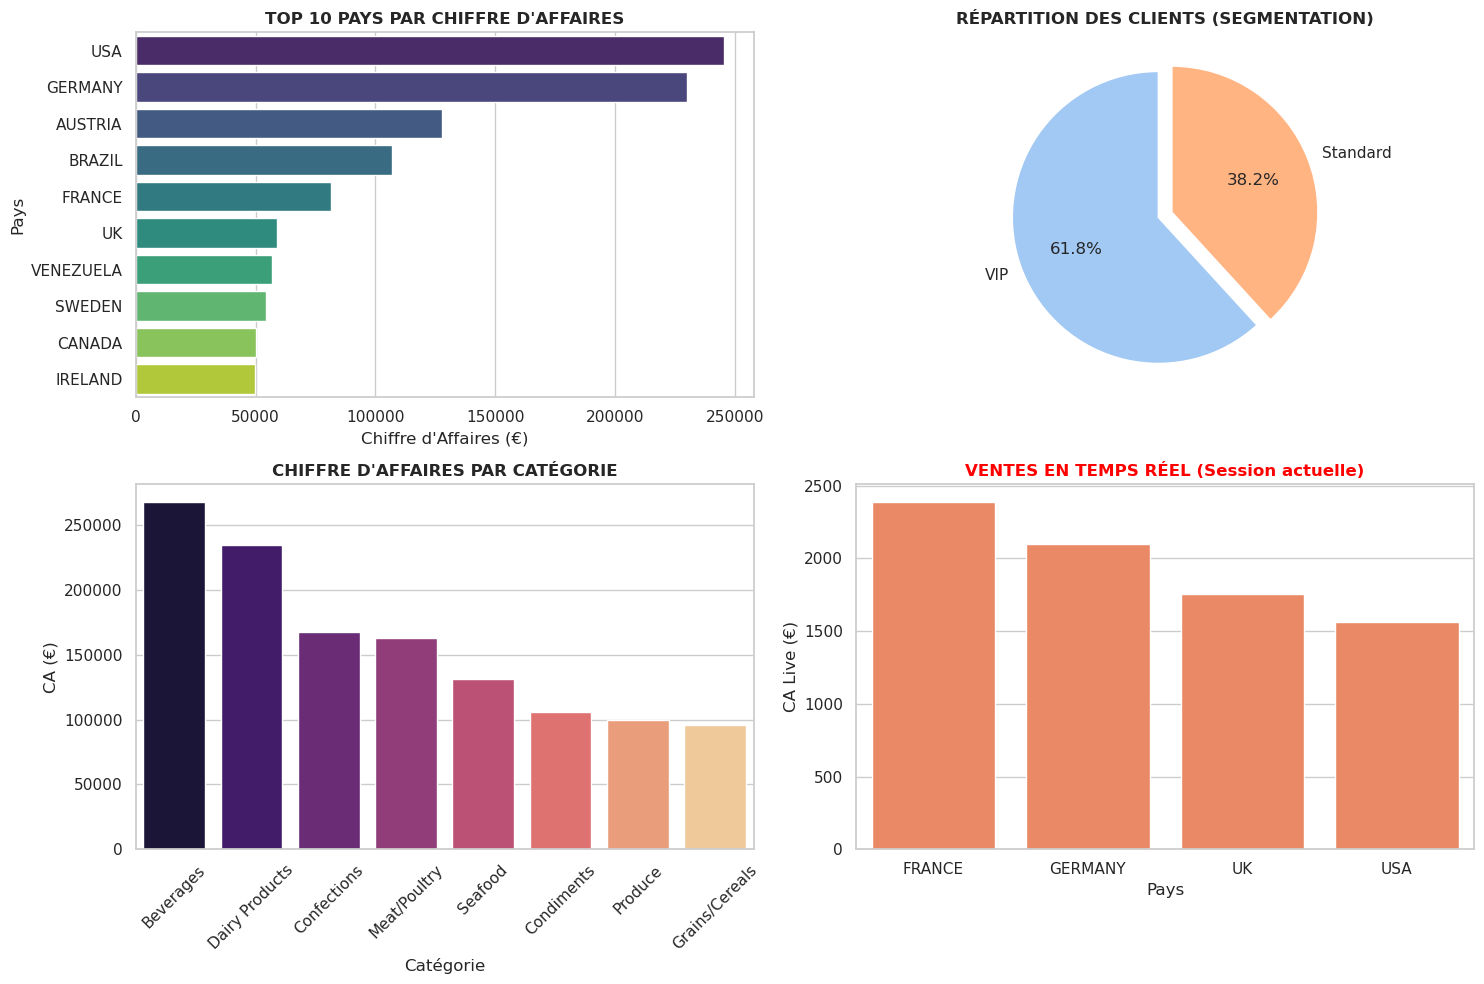

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Configuration esthétique
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("GÉNÉRATION DU DASHBOARD GRAPHIQUE...")

# ---------------------------------------------------------
# GRAPHIQUE 1 : Top 10 des Pays par Chiffre d'Affaires
# ---------------------------------------------------------
# On repart de la table Silver pour avoir tous les pays, pas juste le top 3
df_pays_pd = df_silver.groupBy("pays") \
    .agg(F.sum("montant_final").alias("ca")) \
    .orderBy(F.col("ca").desc()) \
    .limit(10) \
    .toPandas()

plt.subplot(2, 2, 1)
sns.barplot(x="ca", y="pays", data=df_pays_pd, palette="viridis", hue="pays", legend=False)
plt.title("TOP 10 PAYS PAR CHIFFRE D'AFFAIRES", fontsize=12, fontweight='bold')
plt.xlabel("Chiffre d'Affaires (€)")
plt.ylabel("Pays")

# ---------------------------------------------------------
# GRAPHIQUE 2 : Répartition des Segments Clients (Pie Chart)
# ---------------------------------------------------------
# On utilise votre DataFrame Gold existant
df_seg_pd = df_rfm_segment.groupBy("segment").count().toPandas()

plt.subplot(2, 2, 2)
plt.pie(df_seg_pd["count"], labels=df_seg_pd["segment"], autopct='%1.1f%%', 
        colors=sns.color_palette("pastel"), startangle=90, explode=[0.05]*len(df_seg_pd))
plt.title("RÉPARTITION DES CLIENTS (SEGMENTATION)", fontsize=12, fontweight='bold')

# ---------------------------------------------------------
# GRAPHIQUE 3 : Performance par Catégorie de Produit
# ---------------------------------------------------------
# Agrégation rapide depuis Silver
df_cat_pd = df_silver.groupBy("categorie") \
    .agg(F.sum("montant_final").alias("ca")) \
    .orderBy(F.col("ca").desc()) \
    .toPandas()

plt.subplot(2, 2, 3)
sns.barplot(x="categorie", y="ca", data=df_cat_pd, palette="magma", hue="categorie", legend=False)
plt.title("CHIFFRE D'AFFAIRES PAR CATÉGORIE", fontsize=12, fontweight='bold')
plt.xlabel("Catégorie")
plt.ylabel("CA (€)")
plt.xticks(rotation=45)

# ---------------------------------------------------------
# GRAPHIQUE 4 : Comparaison Temps Réel (Streaming)
# ---------------------------------------------------------
# On récupère les données de la vue mémoire du streaming
if df_live.count() > 0:
    df_live_pd = df_live.toPandas().sort_values("total_ventes_live", ascending=False)
    
    plt.subplot(2, 2, 4)
    sns.barplot(x="pays", y="total_ventes_live", data=df_live_pd, color="coral")
    plt.title("VENTES EN TEMPS RÉEL (Session actuelle)", fontsize=12, fontweight='bold', color="red")
    plt.xlabel("Pays")
    plt.ylabel("CA Live (€)")
else:
    # Si pas de données live, on affiche un message
    plt.subplot(2, 2, 4)
    plt.text(0.5, 0.5, "En attente de données live...", 
             horizontalalignment='center', verticalalignment='center', fontsize=14)
    plt.title("MONITORING TEMPS RÉEL", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()